# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/BEE4750/Homeworks/hw2-hutch-s-team`
   Installed Preferences ─────────────── v1.4.0
   Installed JpegTurbo_jll ───────────── v2.1.91+0
   Installed Libmount_jll ────────────── v2.35.0+0
   Installed Accessors ───────────────── v0.1.37
   Installed GR_jll ──────────────────── v0.72.7+0
   Installed Xorg_xkbcomp_jll ────────── v1.4.2+4
   Installed LoggingExtras ───────────── v1.0.0
   Installed RelocatableFolders ──────── v1.0.0
   Installed ConcurrentUtilities ─────── v2.2.0
   Installed InlineStrings ───────────── v1.4.0
   Installed Roots ───────────────────── v2.1.6
   Installed Unitful ─────────────────── v1.14.0
   Installed Contour ─────────────────── v0.6.2
   Installed Formatting ──────────────── v0.4.2
   Installed PlotUtils ───────────────── v1.3.5
   Installed OpenSSL ─────────────────── v1.4.1
   Installed ColorSchemes ────────────── v3.21.0
   Installed Xorg_libpthread_stubs_jll ─ v0.1.0+3
   Installed Fontconfig_jll ──────────── v2.13.93

In [2]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

For a steady state well mixed system concentration is $C_0*e^{kt}$. We want to write this in terms of distance to be able to calucluate concentration at a certain distance.In this case there is two entry streams to consider which start at different distances so we must create two differnet terms. However we don't want to have the second term considered if the distance is less than 15 so we must create a function with if else. To find concentration in distances less than 15:$ \\ $
$Concentartion=C_1*e^{(k*d/10)} \\$
Where:
$\\C_1= (Q_{River}*C_{River}+Q_{Crud_1}*C_{Crud_1})/(Q_{River}+Q_{Crud_1})=1.6724\ \\ Concentartion=1.6724*e^{(-0.36*d/10)}$ 

To find concentration in distances larger than 15 it is more complicated. You can not simply take the rivers concentration at 15 and the inlet because the crud decays exponentially. We must have two terms one of the river concentration which has began decaying multiplied by the river rate and another with the inlet Crud concentration multiplied by the rate of the river: $\\$ 
$Concentration=\\(Q_{River}*C_1*e^{(k*d/10)}+Q_{Crud_2}*C_{Crud_2}*e^{(k*(d-15)/10)})/(Q_{River}+Q_{Crud_2})\\$
$Concentration=\\(250*1.6724*e^{(k*d/10)}+420*e^{(k*(d-15)/10)})/310$

max_concentration = 2.140796917153436


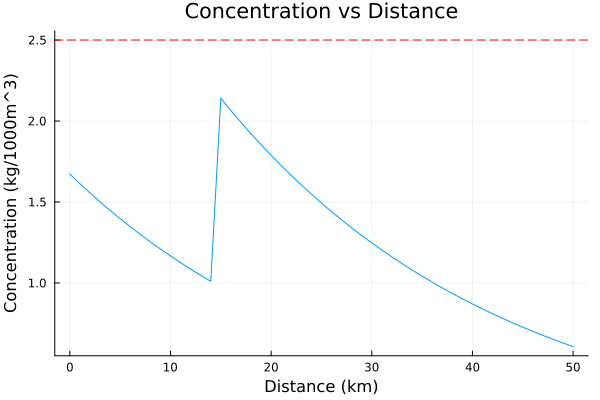

In [50]:
function concentration(d)
    if d < 15
        c= 1.6724*(ℯ^(-0.36*(d/10)))
    else
        c=(1.6724*(ℯ^(-0.36*(d/10)))*250+420*(ℯ^(-0.36*(d-15)/10)))/310
    end
    return c
end

d_values=0:1:50
c_values= [concentration(d) for d in d_values]
max_concentration= maximum(c_values)
@show max_concentration
plot(d_values, c_values, xlabel="Distance (km)", ylabel="Concentration (kg/1000m^3)",
     title="Concentration vs Distance", legend=false)
     hline!([2.5], linestyle = :dash, color = :red, label = "Regulatory Limit (20 kg/1000 m^3)")

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.